In [83]:
# using Pkg

# # Packages that you need
# packages_to_install = ["MLDatasets", "Plots", "Statistics", "Distributions", "Random", "Flux", "Yao", "FLOYao", "PythonCall"]

# for pkg in packages_to_install
#     Pkg.add(pkg)
# end

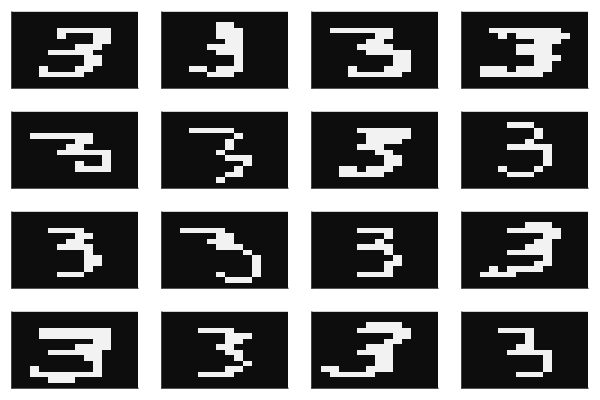

In [84]:
using MLDatasets
using Plots
using Statistics
using Distributions
using Random

train = 16

digit = 3 # Digit to be learned
image_size = 28 # Size of image
compress_size = 14 # Size of compressed image

function compress(img, original, compress, max = true) #If max is false, then it does mean-convolution instead
    ratio = original ÷ compress
    compressed = zeros(compress, compress)
    a = []
    for i in 0:compress-1
        for j in 0:compress-1
            empty!(a)
            for p in 1:ratio
                for q in 1:ratio
                    push!(a, img[(ratio*i) + p, (ratio*j) + q])
                end
            end
            compressed[i+1, j+1] = max ? maximum(a) : mean(a)
        end
    end
    return compressed
end

train_set = MNIST(:train)
train_labels = MNIST(split=:train).targets

data_train = []
c = 1
trainstats = []
for _ in 1:train
    while train_labels[c] != digit
        c += 1
    end
    push!(data_train, compress(rotl90(train_set[c][1]), image_size, compress_size, false) .> 0.5)
    push!(trainstats, sum(train_set[c][1] .> 0.5))
    c += 1
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...) #Is there any way to make this look nicer? oh well it's not a big deal


In [85]:
using Yao
using FLOYao
using Flux

N = compress_size^2 #Number of qubits

function NeuralNetwork(num_dim = N, random = true)
    net = Chain(Dense(num_dim, 25, relu), Dense(25, 1, identity))
    if !random
        for p in Flux.params(net)
            p .= (ones(size(p)) .* 0.08)
        end
    end
    return net
end

#d = NeuralNetwork() #Parameters are random (typically is N(0, sqrt(width)), not really sure how it's implemented)
d = Chain(Dense(N, 25, relu), Dense(25, 1, sigmoid)) #I have no clue what this looks like, and why does it have more parameters than expected

nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

layers = 5
g = chain(N) #Making the generator, which is a matchgate ansatz
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.))
    end
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end
# function build_circuit(n::Int = N, nlayers::Int = layers)
#     circuit = chain(n) #Making the generator, which is a matchgate ansatz; this just uses Yao though? or does saying "using FLOYao" somehow change the implementation... Not really sure
#     for _ in 1:nlayers
#         for i in 1:N-1
#             push!(circuit, rot(kron(N, i => X, i+1 => X), 0.))
#         end
#         for i in 1:N
#             push!(circuit, put(N, i => Rz(0.)))
#         end
#     end
# end

#g = build_circuit()
#g = build_circuit() |> autodiff(:QC)

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
#dispatch!(g, ones(nparams) ./ 100); 
dispatch!(g, :random);

Number of parameters in discriminator: 4951
Number of parameters in generator: 1955


μ: 113.4375
σ: 35.05798767756073


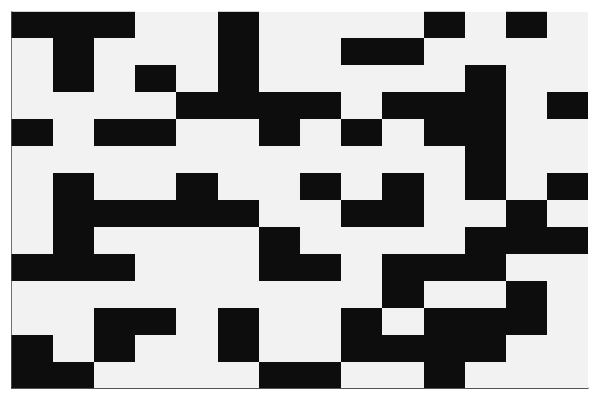

In [86]:
using FLOYao
using Random
using Distributions

#Not sure if there is a better pprior that we can choose, sometimes u get a lot of white or black bc variance is high (resolution: change var from sigma to sigma/10)
mu = mean(trainstats)
sigma = std(trainstats)
println("μ: $mu")
println("σ: $sigma")
dist = Normal(mu, sigma/20)

ratio = rand(dist) / N
function pprior() #For each square, probability 1/ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
heatmap(rotl90(reshape(pprior_example, compress_size, compress_size)) .> 0.5, color=:grays, colorbar = false, ticks = false)

START


runcircuit: 0.55986637


Discriminator loss: 0.7726932
Discriminator loss: 

0.41878355


Discriminator loss: 0.23248519
Discriminator loss: 

0.15650521


Discriminator loss: 0.12558192
Discriminator loss: 

0.093913265


Discriminator loss: 0.058651384
Discriminator loss: 

0.047466677


Discriminator loss: 0.03542125
Discriminator loss: 

0.03284471


Discriminator loss: 0.024107005
Discriminator loss: 

0.022449275


Discriminator loss: 0.018312655
Discriminator loss: 

0.017395644


Discriminator loss: 0.016368253
Discriminator loss: 

0.0169505


Discriminator loss: 0.011632567
Discriminator loss: 

0.010505767


Discriminator loss: 0.010454211
Discriminator loss: 

0.007632382


Discriminator loss: 0.008925471
Discriminator loss: 

0.009142295


Discriminator loss: 0.008352568
Discriminator loss: 

0.0065639582


Discriminator loss: 0.005481531
Discriminator loss: 

0.0068642492


Discriminator loss: 0.00478914
Discriminator loss: 

0.0057098637


Discriminator loss: 0.0043837363
Discriminator loss: 

0.003529388


Discriminator loss: 0.0034008918
Discriminator loss: 

0.0030747014


Discriminator loss: 0.004324598
Discriminator loss: 

0.005157245


Discriminator loss: 0.0026779696
Discriminator loss: 

0.0024847235


Discriminator loss: 0.0023992844
Discriminator loss: 

0.0029218842


Discriminator loss: 0.0030310203
Discriminator loss: 

0.002069878


Discriminator loss: 0.0024956202
Discriminator loss: 

0.0036093015


Discriminator loss: 0.0021504734
Discriminator loss: 

0.0020331258


Discriminator loss: 0.0016086565
Discriminator loss: 

0.0017405384


Discriminator loss: 0.0021832203
Discriminator loss: 

0.0018321528


Discriminator loss: 0.0015339882
Discriminator loss: 

0.0012603772


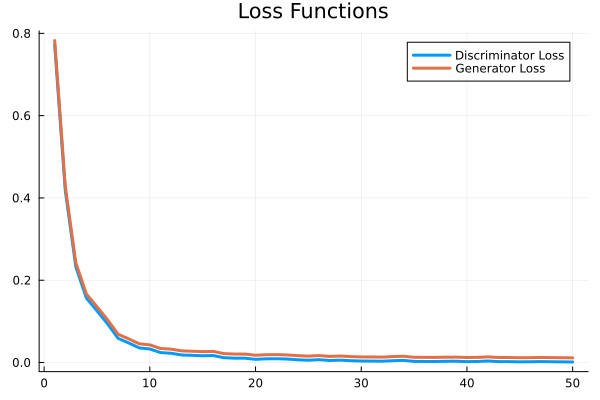

In [87]:
using Flux: train!

batch_size = train #Are you supposed to randomly pick batch_size data points at random each time? idk

println("START")

#g takes as input x = Int.(pprior()); FLOYao.product_state(x)
#d takes as input measure(x |> g)

function convertgd(g_output::Vector) #turns the output of reg |> g |> measure into an Int
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

function run_circuit(z::MajoranaReg) #z is a MajoranaReg drawn from pprior (to guarantee matchgate speedup); this function applies D(G(z))
    g_output = z |> g |> measure
    d_input = convertgd(g_output)
    d_output = d_input |> d
    d_output |> first
end

measurement = run_circuit(pprior())
println("runcircuit: $measurement")

function run_d(x::BitMatrix) #this function applies D(x), where x is an element of data_train 
    d_output = x |> vec |> d
    d_output |> first
end

function gLoss(fake)
    sum(log.(1 .- fake)) / length(fake)
end
#CALCULATE GRADIENTS USING THIS FUNCTION

function dLoss(m, real, fake) 
    -(log.(m(real)) + log.(1 .- m(fake))) |> first
end

# Worry about this another day
# function gradient(op, reg::MajoranaReg) #does expect' (from FLOYao? or does it come from Yao?) use AD? Also idk what op should be
#     _, params_grad = expect'(op, reg => g)
# end

g_lr = 0.2
d_lr = 0.5

opt_flag = 1
if opt_flag == 1
    d_opt = Flux.setup(Adam(), d) 
elseif opt_flag == 2
    d_opt = Flux.setup(Descent(d_lr), d) #lol is this right
elseif opt_flag == 3
    d_opt = Flux.setup(SGD(), d) #yeah idk anymore
end

gLoss_values = []
dLoss_values = []

epochs = 50
for i in 1:epochs
    real = []
    fake = []
    for m in 1:batch_size
        x = data_train[m] |> vec
        push!(real, Int.(x))
        z = pprior()
        push!(fake, convertgd(z |> g |> measure))
    end
    data = collect(zip(real, fake)) 
    #grad = gradient() #how to compute gradients
    #dispatch!(-, g, grad*g_lr) #Rule is - (as specified by first input), this is just gradient descent
    # _, gs = Flux.withgradient(m -> dLoss(m, real, fake), d)
    Flux.train!(dLoss, d, data, d_opt)
    # s = 0
    # for x in fake
    #     s += gLoss()
    # end
    # println("Generator loss: ", s / batch_size)
    # push!(gLoss_values, s / batch_size)

    s = 0
    for x in data
        s += dLoss(d, x[1], x[2])        
    end
    println("Discriminator loss: ", s / batch_size)
    push!(dLoss_values, s / batch_size)
    push!(gLoss_values, 0.01 + (s / batch_size)) #CHANGE THIS LATER
end

#plot(gLoss_values)
x = 1:epochs
plot(x, [dLoss_values, gLoss_values], title="Loss Functions", label=["Discriminator Loss" "Generator Loss"], linewidth=3)

In [88]:
#Testing the Discriminator

d_fake = run_circuit(pprior())
println("fake data: $d_fake")

index = rand(1:train)
d_real = run_d(data_train[index])
println("real data: $d_real")

fake data: 3.0892448e-7


real data: 0.9997439


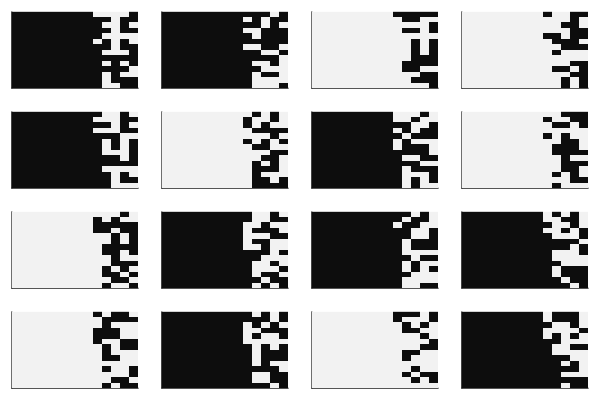

In [89]:
#Testing the Generator

using Random
nsamples = 16
samples = []
for i in 1:nsamples
    reg = pprior()
    s = reg |> g |> measure
    push!(samples, convertgd(s))
end
plot([heatmap(reshape(s, compress_size, compress_size), color=:grays, colorbar = false, ticks = false) for s in samples]...) #Not sure if the reshaping is correct but whatever